<a href="https://colab.research.google.com/github/2003UJAN/Alzheimer-MRI/blob/main/Alzeihmer-MRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [133]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'mri-and-alzheimers:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1980%2F3398%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240601%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240601T104432Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D308297779fe3df34fee0b4fcce0f52682661fc0c750a52d31b1c2fad661e83e1655e8fd593789de76e799e00f2177c7ece7168322ff8273fee924fafafc8d047f191868748bfe916994ced1684299e6fe88750fffe73681ef3ffe10be4ca500cea496b19ec52420ee1eb9e59801bad0d524ddecb7c9fd1bb37bd7e75fdea64ad01dceff8a6c0b0b804daf0bb7af2a75b57175f00021344b10765f3c8d4af514c6a934bd60a801c4f41c0baca53480d955f247e9cf39360a18cdfecee5550b6834a8b0f5c8b2827142494f6cc3a934f7efd9360ba14d440017da6fbef705023a99f097d8afe140130d0abb691fba9cbbe912e0eb9b90e7a0deda57373c536019f'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 12924 bytes downloaded
Downloaded and uncompressed: mri-and-alzheimers
Data source import complete.


In [134]:
pip install catboost

In [135]:
import numpy as np
import pandas as pd
import catboost
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/mri-and-alzheimers/oasis_longitudinal.csv
/kaggle/input/mri-and-alzheimers/oasis_cross-sectional.csv


In [136]:
data_cross = pd.read_csv('/kaggle/input/mri-and-alzheimers/oasis_cross-sectional.csv')
data_cross.head()

,ID,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay
0,OAS1_0001_MR1,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,NaN
1,OAS1_0002_MR1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,NaN
2,OAS1_0003_MR1,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207,NaN
3,OAS1_0004_MR1,M,R,28,NaN,NaN,NaN,NaN,1588,0.803,1.105,NaN
4,OAS1_0005_MR1,M,R,18,NaN,NaN,NaN,NaN,1737,0.848,1.010,NaN


In [137]:
data_long = pd.read_csv('/kaggle/input/mri-and-alzheimers/oasis_longitudinal.csv')
data_long.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


In [138]:
data_long = data_long.rename(columns={'EDUC':'Educ'})


In [139]:
data = pd.concat([data_cross, data_long])
data.head()

,ID,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay,Subject ID,MRI ID,Group,Visit,MR Delay
0,OAS1_0001_MR1,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,NaN,NaN,NaN,NaN,NaN,NaN
1,OAS1_0002_MR1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,NaN,NaN,NaN,NaN,NaN,NaN
2,OAS1_0003_MR1,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207,NaN,NaN,NaN,NaN,NaN,NaN
3,OAS1_0004_MR1,M,R,28,NaN,NaN,NaN,NaN,1588,0.803,1.105,NaN,NaN,NaN,NaN,NaN,NaN
4,OAS1_0005_MR1,M,R,18,NaN,NaN,NaN,NaN,1737,0.848,1.010,NaN,NaN,NaN,NaN,NaN,NaN


In [140]:
import warnings
warnings.filterwarnings("ignore")


In [141]:
data.shape

(809, 17)

In [142]:
data.dtypes


ID             object
M/F            object
Hand           object
Age             int64
Educ          float64
SES           float64
MMSE          float64
CDR           float64
eTIV            int64
nWBV          float64
ASF           float64
Delay         float64
Subject ID     object
MRI ID         object
Group          object
Visit         float64
MR Delay      float64
dtype: object

In [143]:
data.describe()


,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay,Visit,MR Delay
count,809.000000,608.000000,570.00000,606.000000,608.000000,809.000000,809.000000,809.000000,20.00000,373.000000,373.000000
mean,63.186650,10.184211,2.47193,27.234323,0.288651,1484.782447,0.763037,1.197311,20.55000,1.882038,595.104558
std,23.117511,6.058388,1.12805,3.687980,0.377697,166.911689,0.059401,0.133031,23.86249,0.922843,635.485118
min,18.000000,1.000000,1.00000,4.000000,0.000000,1106.000000,0.644000,0.876000,1.00000,1.000000,0.000000
25%,49.000000,4.000000,2.00000,26.000000,0.000000,1361.000000,0.715000,1.108000,2.75000,1.000000,0.000000
50%,72.000000,12.000000,2.00000,29.000000,0.000000,1475.000000,0.754000,1.190000,11.00000,2.000000,552.000000
75%,80.000000,16.000000,3.00000,30.000000,0.500000,1583.000000,0.817000,1.290000,30.75000,2.000000,873.000000
max,98.000000,23.000000,5.00000,30.000000,2.000000,2004.000000,0.893000,1.587000,89.00000,5.000000,2639.000000


In [144]:
data.isnull().sum()

ID            373
M/F             0
Hand            0
Age             0
Educ          201
SES           239
MMSE          203
CDR           201
eTIV            0
nWBV            0
ASF             0
Delay         789
Subject ID    436
MRI ID        436
Group         436
Visit         436
MR Delay      436
dtype: int64

In [145]:
for column in data.columns:
    mode_value = data[column].mode()[0]
    data[column].fillna(mode_value, inplace=True)

missing_values_after_filling = data.isnull().sum()
print(missing_values_after_filling)


ID            0
M/F           0
Hand          0
Age           0
Educ          0
SES           0
MMSE          0
CDR           0
eTIV          0
nWBV          0
ASF           0
Delay         0
Subject ID    0
MRI ID        0
Group         0
Visit         0
MR Delay      0
dtype: int64


In [146]:
data.head()

,ID,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay,Subject ID,MRI ID,Group,Visit,MR Delay
0,OAS1_0001_MR1,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,2.0,OAS2_0048,OAS2_0001_MR1,Nondemented,1.0,0.0
1,OAS1_0002_MR1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,2.0,OAS2_0048,OAS2_0001_MR1,Nondemented,1.0,0.0
2,OAS1_0003_MR1,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207,2.0,OAS2_0048,OAS2_0001_MR1,Nondemented,1.0,0.0
3,OAS1_0004_MR1,M,R,28,12.0,2.0,30.0,0.0,1588,0.803,1.105,2.0,OAS2_0048,OAS2_0001_MR1,Nondemented,1.0,0.0
4,OAS1_0005_MR1,M,R,18,12.0,2.0,30.0,0.0,1737,0.848,1.010,2.0,OAS2_0048,OAS2_0001_MR1,Nondemented,1.0,0.0


array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Educ'}>,
        <Axes: title={'center': 'SES'}>],
       [<Axes: title={'center': 'MMSE'}>,
        <Axes: title={'center': 'CDR'}>,
        <Axes: title={'center': 'eTIV'}>],
       [<Axes: title={'center': 'nWBV'}>,
        <Axes: title={'center': 'ASF'}>,
        <Axes: title={'center': 'Delay'}>],
       [<Axes: title={'center': 'Visit'}>,
        <Axes: title={'center': 'MR Delay'}>, <Axes: >]], dtype=object)

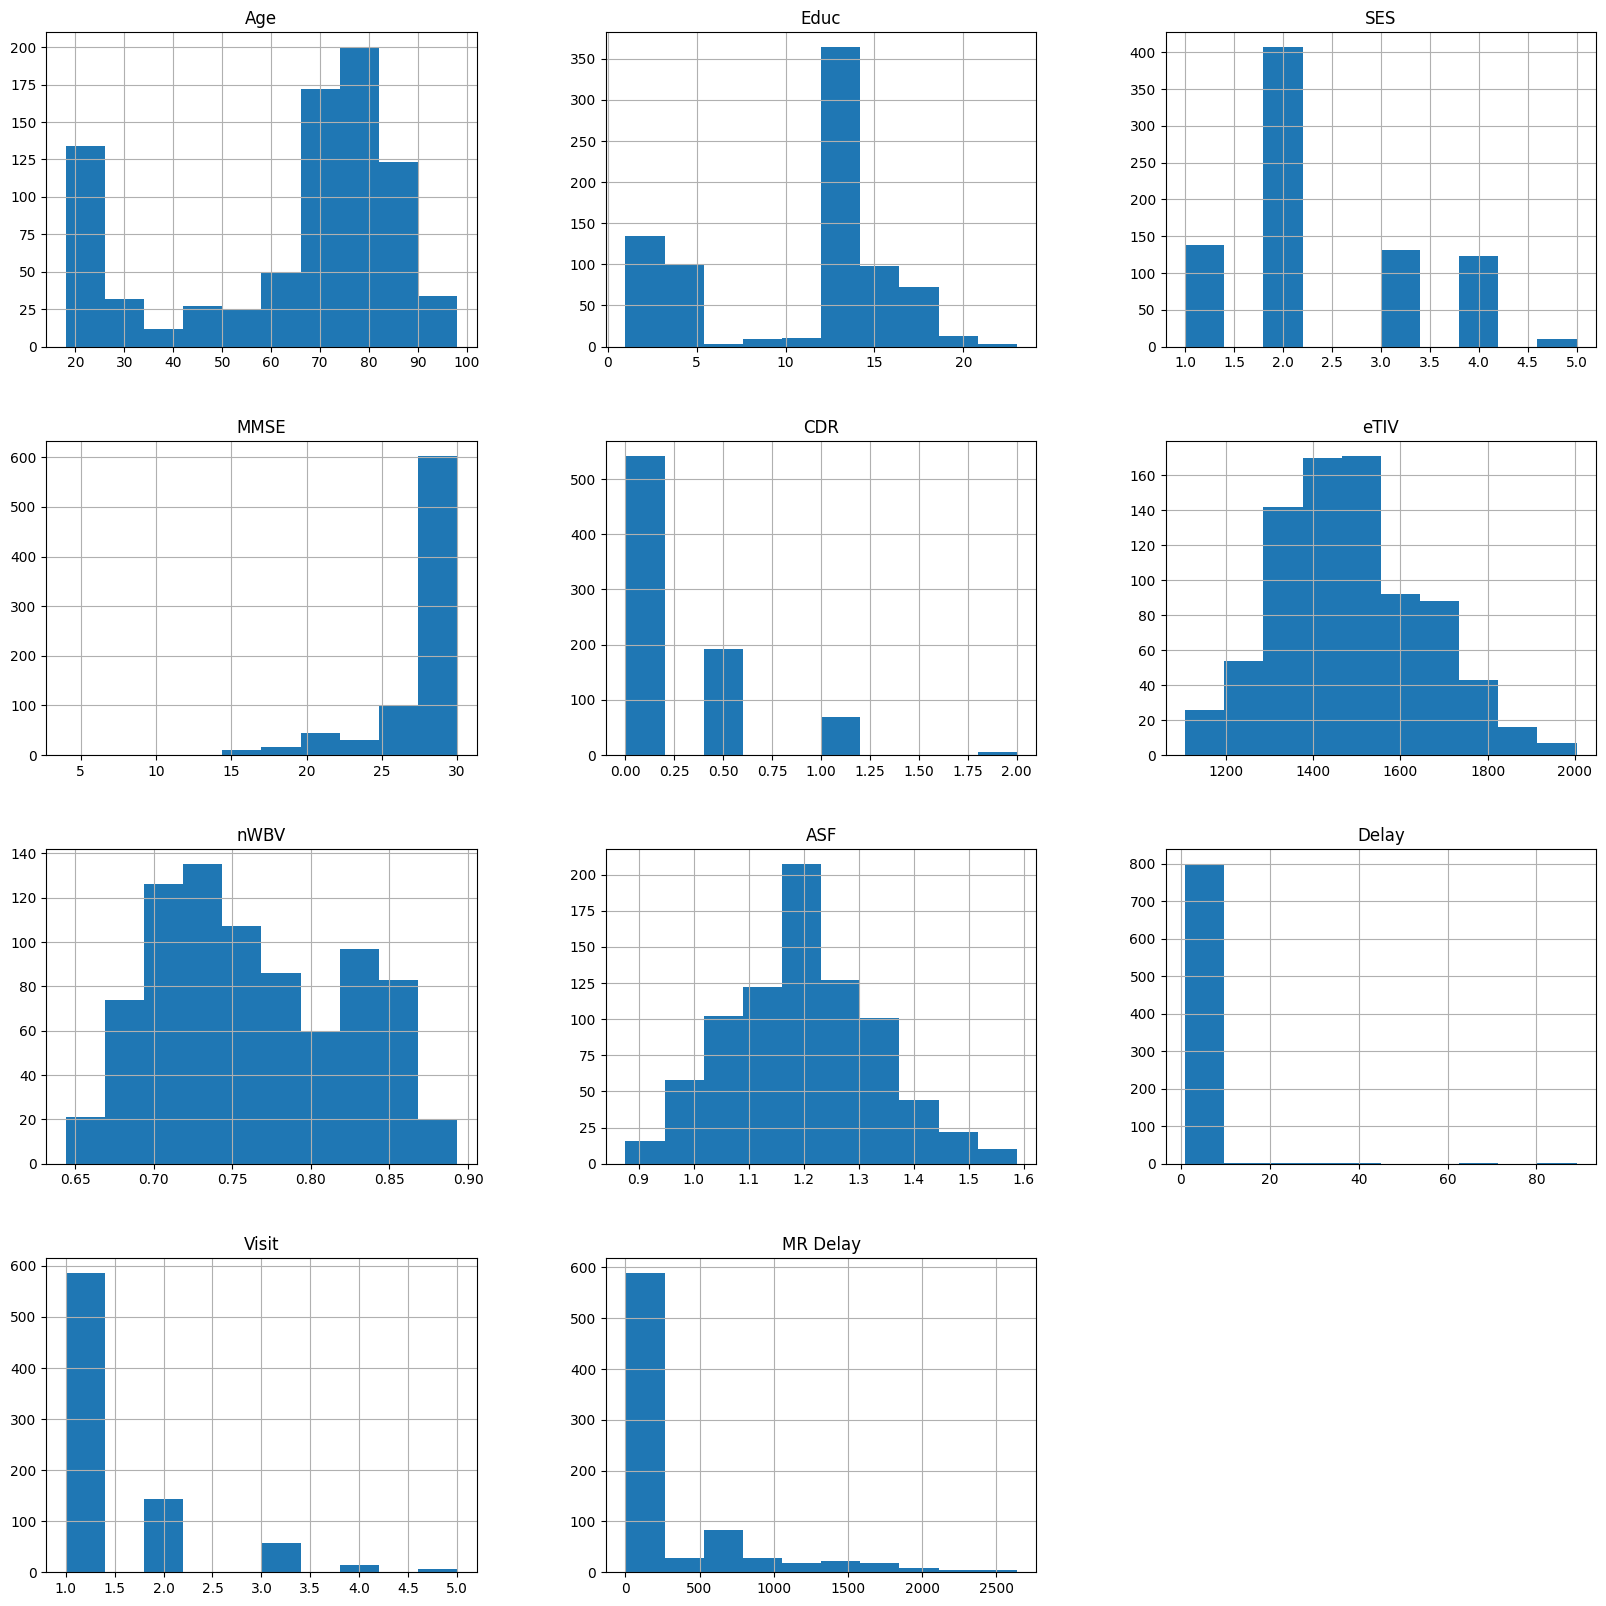

In [147]:
data.hist(figsize = (20,20))


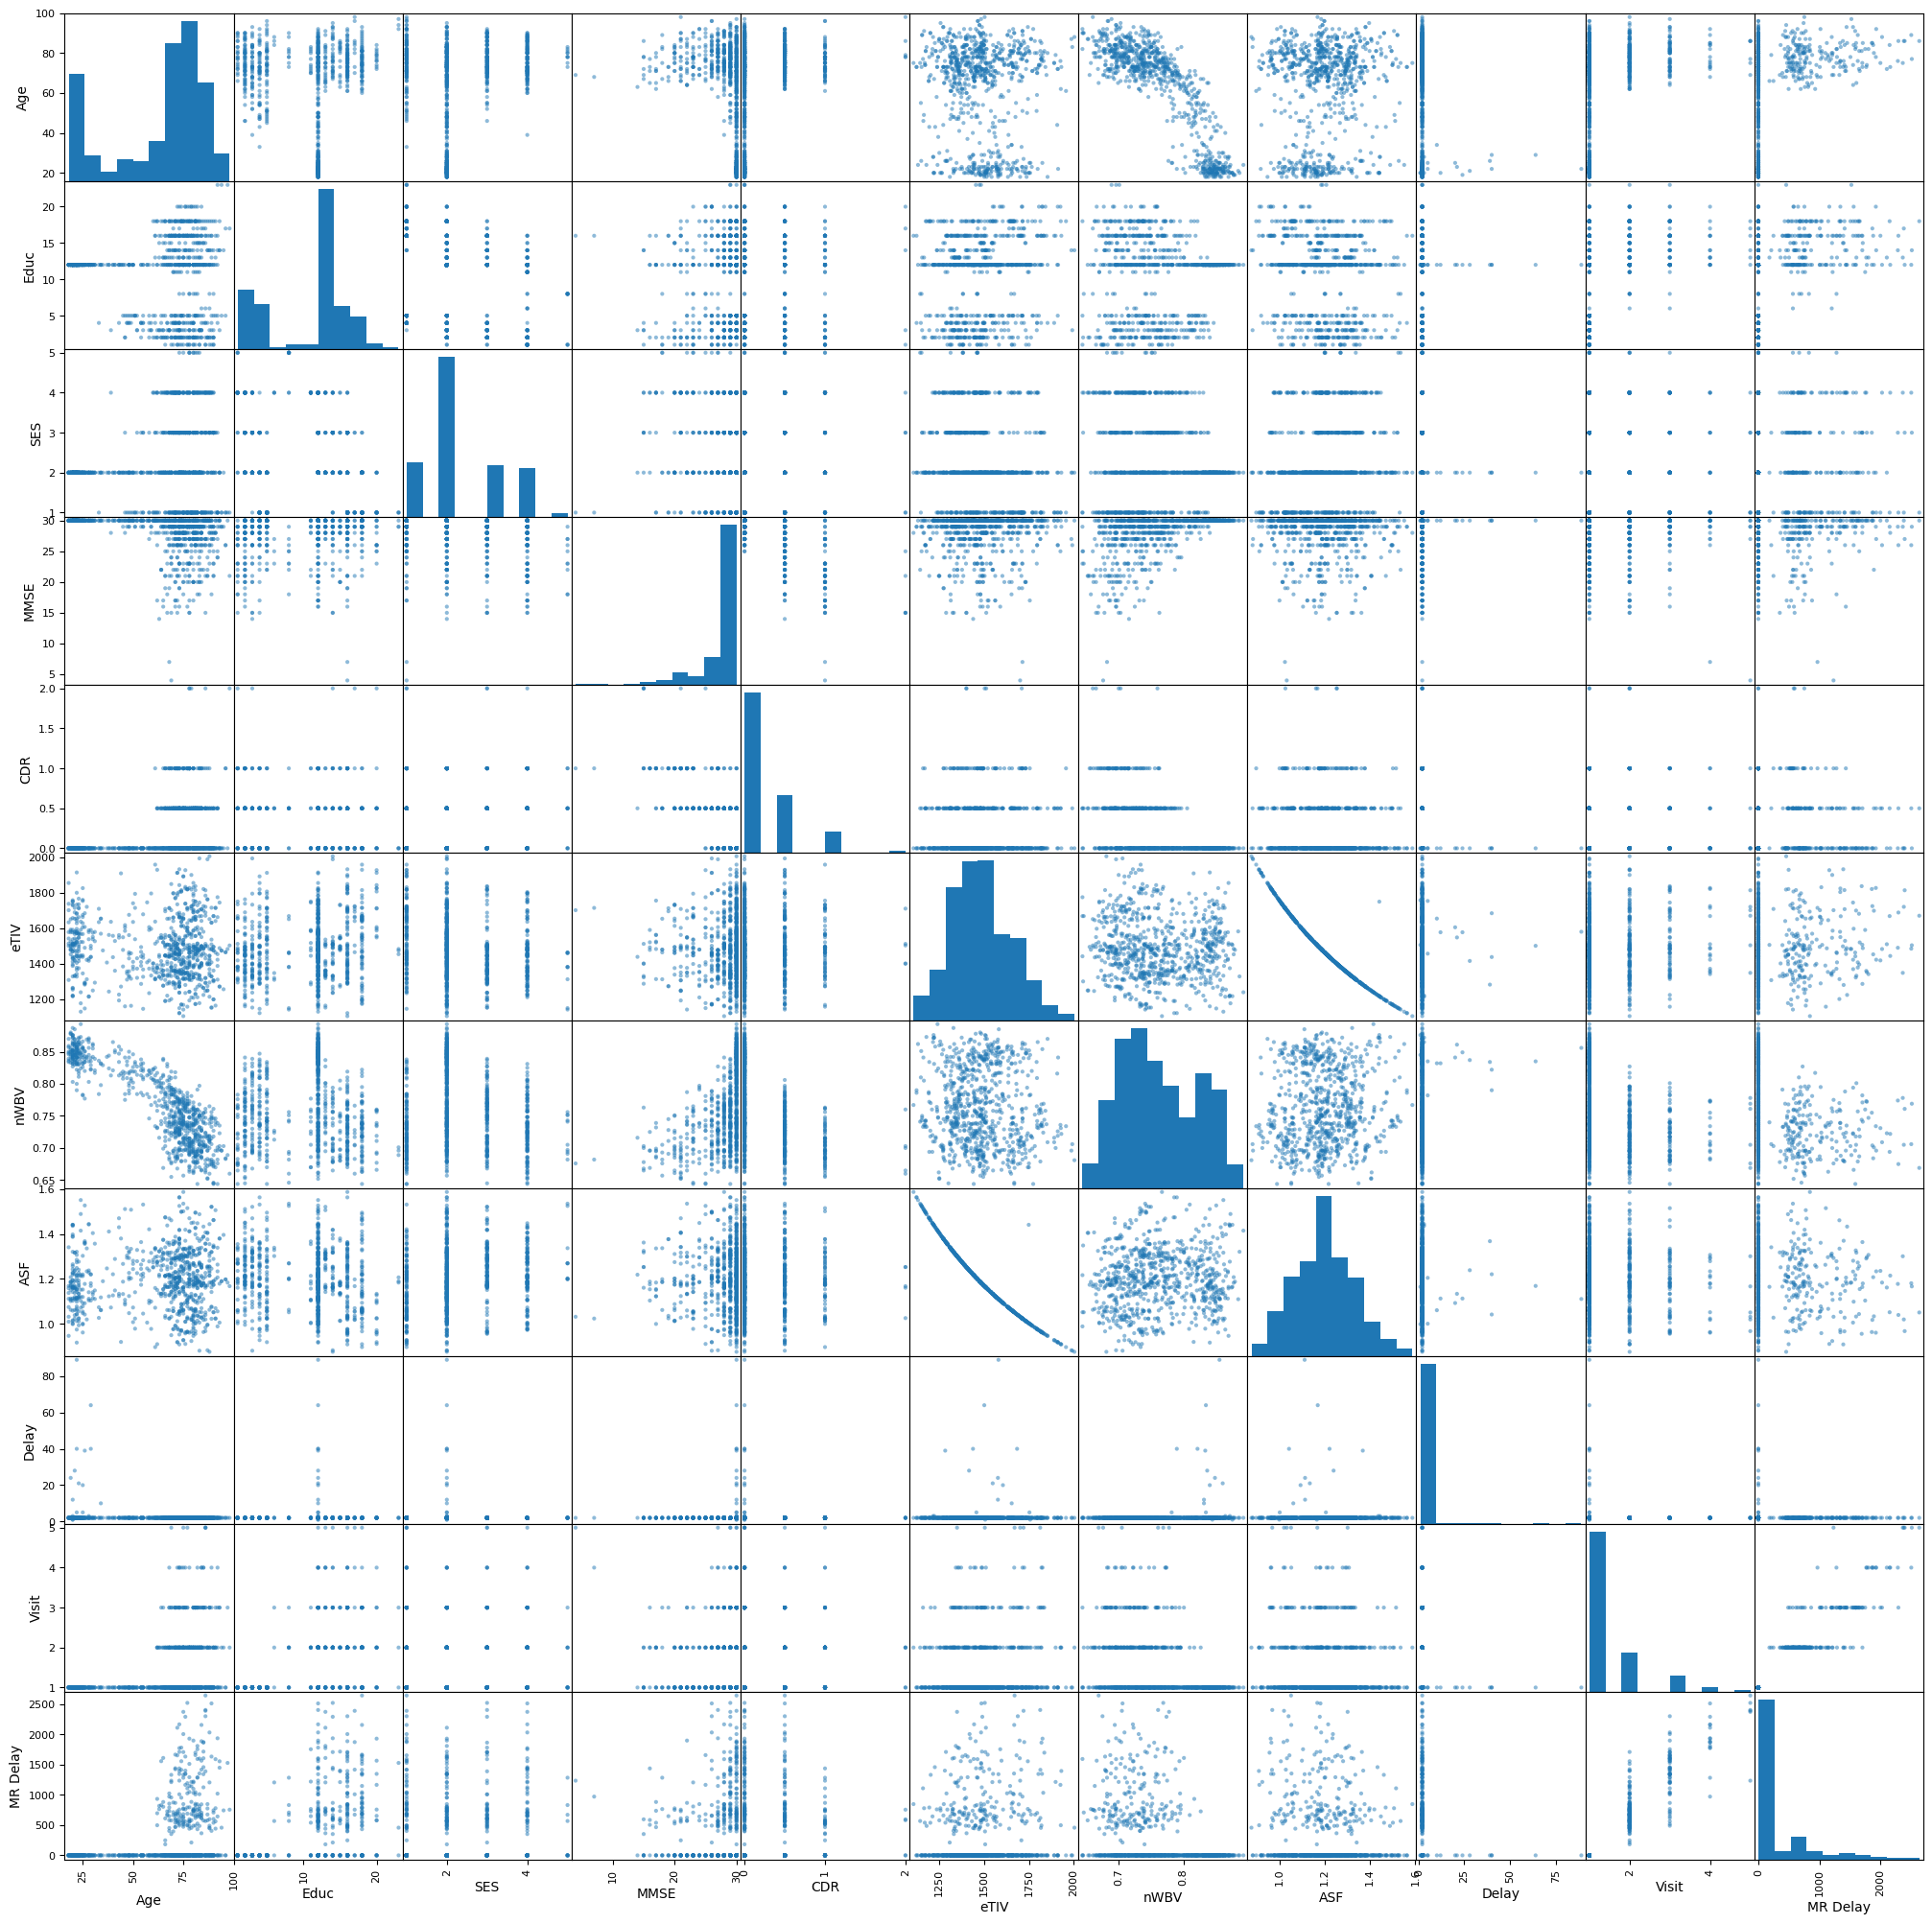

In [148]:
from pandas.plotting import scatter_matrix
p=scatter_matrix(data,figsize=(25, 25))

(15.3, 30.0)

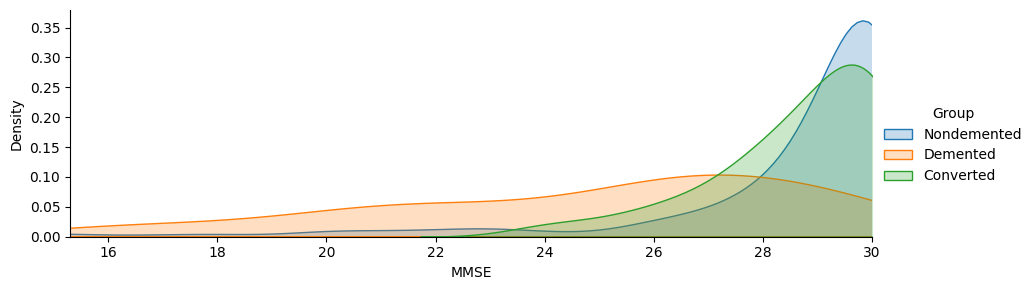

In [149]:
import seaborn as sns
import matplotlib.pyplot as plt

facet= sns.FacetGrid(data,hue="Group", aspect=3)
facet.map(sns.kdeplot,'MMSE',shade= True)
facet.set(xlim=(0, data['MMSE'].max()))
facet.add_legend()
plt.xlim(15.30)

(0.6, 0.9)

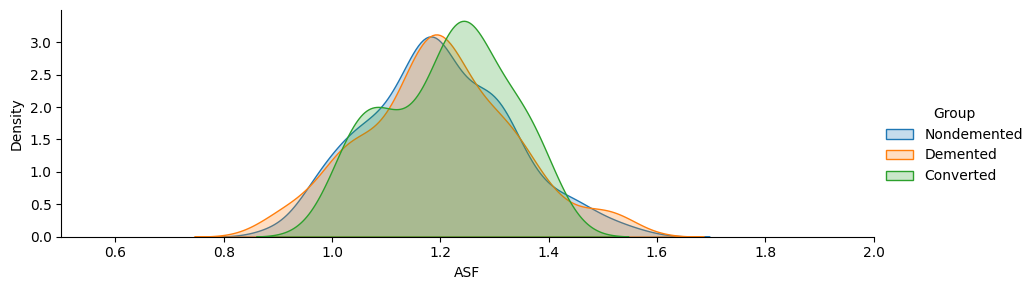

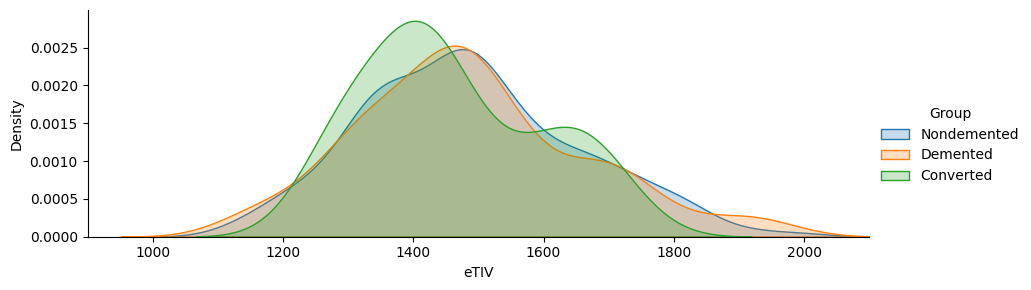

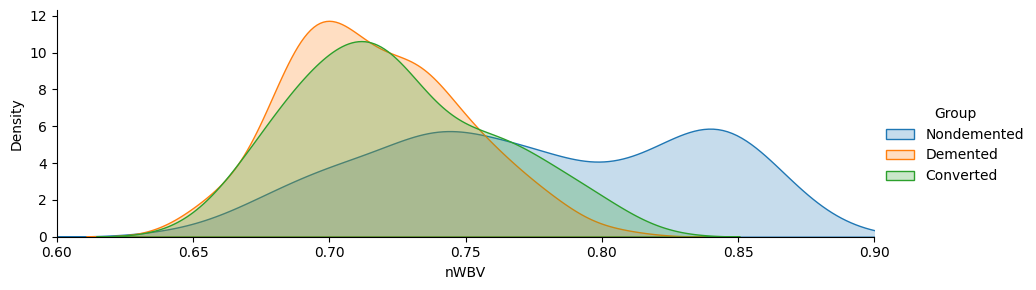

In [150]:
facet= sns.FacetGrid(data,hue="Group", aspect=3)
facet.map(sns.kdeplot,'ASF',shade= True)
facet.set(xlim=(0, data['ASF'].max()))
facet.add_legend()
plt.xlim(0.5, 2)

facet= sns.FacetGrid(data,hue="Group", aspect=3)
facet.map(sns.kdeplot,'eTIV',shade= True)
facet.set(xlim=(0, data['eTIV'].max()))
facet.add_legend()
plt.xlim(900, 2100)


facet= sns.FacetGrid(data,hue="Group", aspect=3)
facet.map(sns.kdeplot,'nWBV',shade= True)
facet.set(xlim=(0, data['nWBV'].max()))
facet.add_legend()
plt.xlim(0.6,0.9)

(50.0, 100.0)

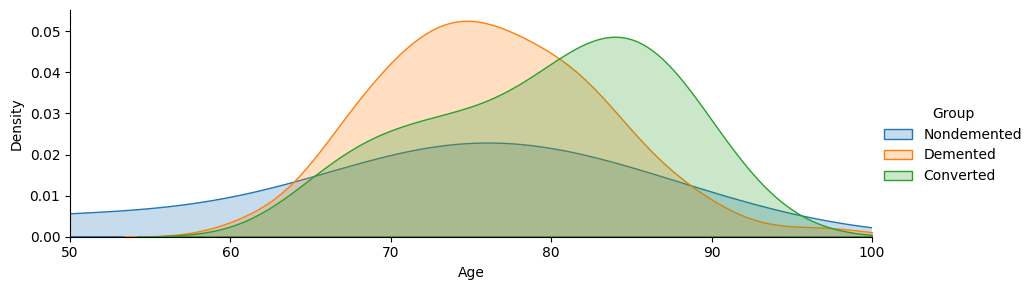

In [151]:
facet= sns.FacetGrid(data,hue="Group", aspect=3)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, data['Age'].max()))
facet.add_legend()
plt.xlim(50,100)

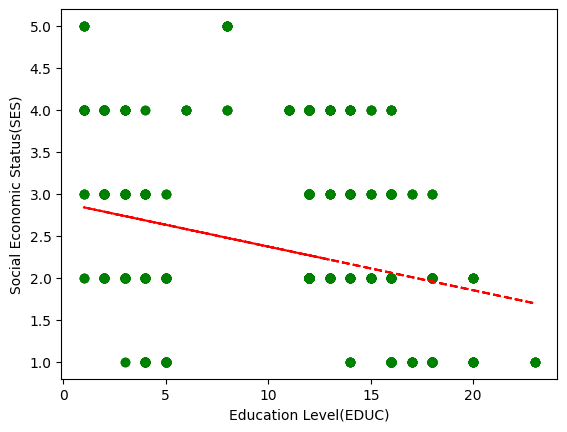

In [152]:
x = data['Educ']
y = data['SES']

ses_not_null_index = y[~y.isnull()].index
x = x[ses_not_null_index]
y = y[ses_not_null_index]

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, y, 'go', x, p(x), "r--")
plt.xlabel('Education Level(EDUC)')
plt.ylabel('Social Economic Status(SES)')

plt.show()

In [153]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

In [154]:
data.head()

,ID,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay,Subject ID,MRI ID,Group,Visit,MR Delay
0,OAS1_0001_MR1,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,2.0,OAS2_0048,OAS2_0001_MR1,Nondemented,1.0,0.0
1,OAS1_0002_MR1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,2.0,OAS2_0048,OAS2_0001_MR1,Nondemented,1.0,0.0
2,OAS1_0003_MR1,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207,2.0,OAS2_0048,OAS2_0001_MR1,Nondemented,1.0,0.0
3,OAS1_0004_MR1,M,R,28,12.0,2.0,30.0,0.0,1588,0.803,1.105,2.0,OAS2_0048,OAS2_0001_MR1,Nondemented,1.0,0.0
4,OAS1_0005_MR1,M,R,18,12.0,2.0,30.0,0.0,1737,0.848,1.010,2.0,OAS2_0048,OAS2_0001_MR1,Nondemented,1.0,0.0


In [155]:
data.columns

Index(['ID', 'M/F', 'Hand', 'Age', 'Educ', 'SES', 'MMSE', 'CDR', 'eTIV',
       'nWBV', 'ASF', 'Delay', 'Subject ID', 'MRI ID', 'Group', 'Visit',
       'MR Delay'],
      dtype='object')

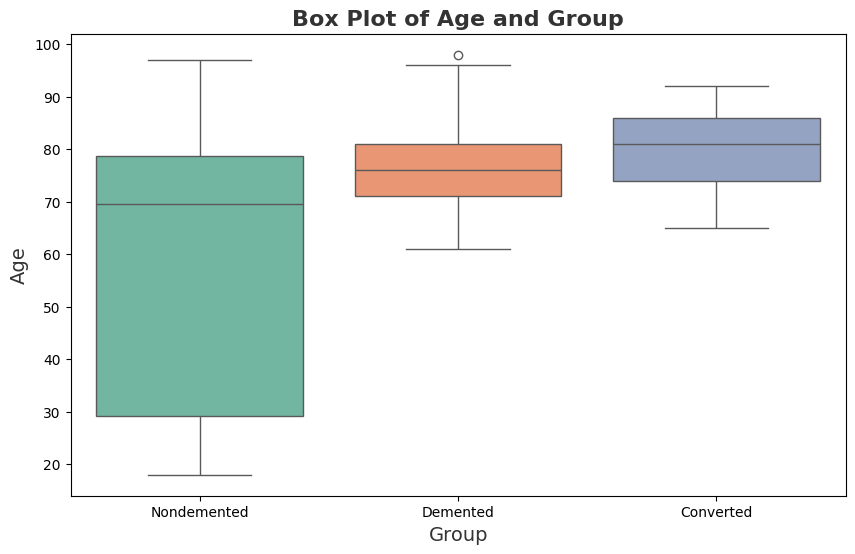

In [156]:
import pandas as pd

plt.figure(figsize=(10, 6))
sns.boxplot(x='Group', y='Age', data=data, palette='Set2')
plt.title('Box Plot of Age and Group', fontsize=16, fontweight='bold', color='#333333')
plt.xlabel('Group', fontsize=14, color='#333333')
plt.ylabel('Age', fontsize=14, color='#333333')
plt.show()

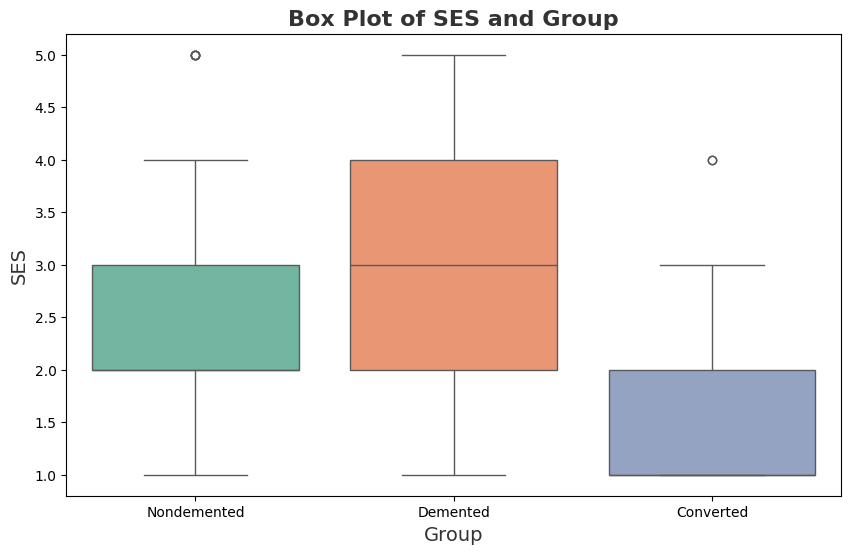

In [157]:
import pandas as pd

plt.figure(figsize=(10, 6))
sns.boxplot(x='Group', y='SES', data=data, palette='Set2')
plt.title('Box Plot of SES and Group', fontsize=16, fontweight='bold', color='#333333')
plt.xlabel('Group', fontsize=14, color='#333333')
plt.ylabel('SES', fontsize=14, color='#333333')
plt.show()

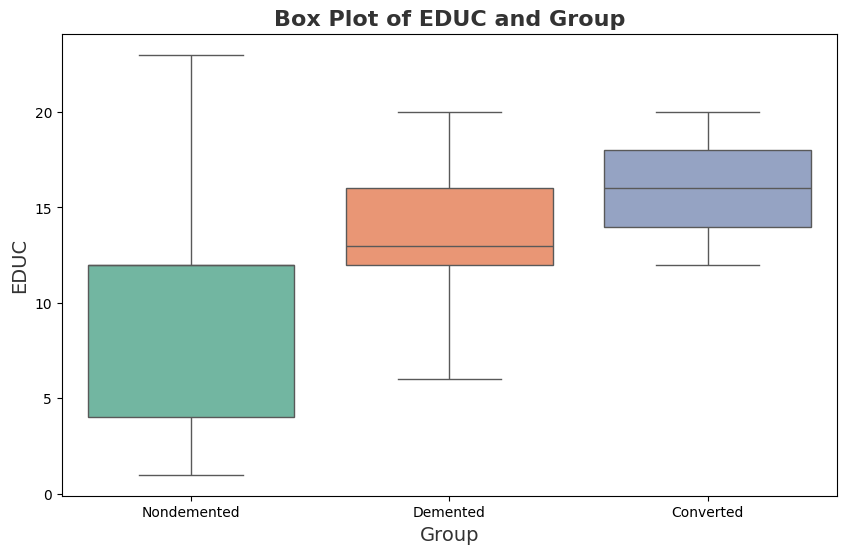

In [158]:
import pandas as pd

plt.figure(figsize=(10, 6))
sns.boxplot(x='Group', y='Educ', data=data, palette='Set2')
plt.title('Box Plot of EDUC and Group', fontsize=16, fontweight='bold', color='#333333')
plt.xlabel('Group', fontsize=14, color='#333333')
plt.ylabel('EDUC', fontsize=14, color='#333333')
plt.show()

<Axes: title={'center': 'Normal Distribution'}, xlabel='SES', ylabel='Density'>

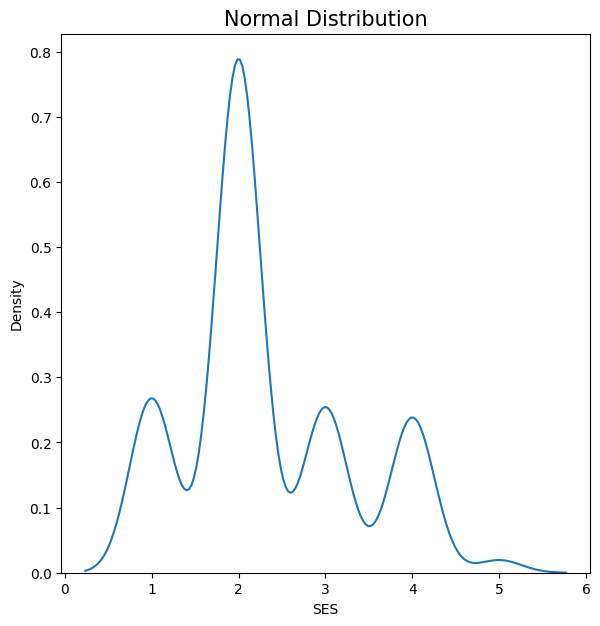

In [159]:
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.title("Normal Distribution", fontsize=15)
sns.kdeplot(data = data["SES"])

In [160]:
data

,ID,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay,Subject ID,MRI ID,Group,Visit,MR Delay
0,OAS1_0001_MR1,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,2.0,OAS2_0048,OAS2_0001_MR1,Nondemented,1.0,0.0
1,OAS1_0002_MR1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,2.0,OAS2_0048,OAS2_0001_MR1,Nondemented,1.0,0.0
2,OAS1_0003_MR1,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207,2.0,OAS2_0048,OAS2_0001_MR1,Nondemented,1.0,0.0
3,OAS1_0004_MR1,M,R,28,12.0,2.0,30.0,0.0,1588,0.803,1.105,2.0,OAS2_0048,OAS2_0001_MR1,Nondemented,1.0,0.0
4,OAS1_0005_MR1,M,R,18,12.0,2.0,30.0,0.0,1737,0.848,1.010,2.0,OAS2_0048,OAS2_0001_MR1,Nondemented,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,OAS1_0001_MR1,M,R,82,16.0,1.0,28.0,0.5,1693,0.694,1.037,2.0,OAS2_0185,OAS2_0185_MR2,Demented,2.0,842.0
369,OAS1_0001_MR1,M,R,86,16.0,1.0,26.0,0.5,1688,0.675,1.040,2.0,OAS2_0185,OAS2_0185_MR3,Demented,3.0,2297.0
370,OAS1_0001_MR1,F,R,61,13.0,2.0,30.0,0.0,1319,0.801,1.331,2.0,OAS2_0186,OAS2_0186_MR1,Nondemented,1.0,0.0
371,OAS1_0001_MR1,F,R,63,13.0,2.0,30.0,0.0,1327,0.796,1.323,2.0,OAS2_0186,OAS2_0186_MR2,Nondemented,2.0,763.0


In [161]:
data.dtypes

ID             object
M/F            object
Hand           object
Age             int64
Educ          float64
SES           float64
MMSE          float64
CDR           float64
eTIV            int64
nWBV          float64
ASF           float64
Delay         float64
Subject ID     object
MRI ID         object
Group          object
Visit         float64
MR Delay      float64
dtype: object

In [162]:
data.columns

Index(['ID', 'M/F', 'Hand', 'Age', 'Educ', 'SES', 'MMSE', 'CDR', 'eTIV',
       'nWBV', 'ASF', 'Delay', 'Subject ID', 'MRI ID', 'Group', 'Visit',
       'MR Delay'],
      dtype='object')

In [163]:
X = data.drop(['Group', 'ID', 'Delay', 'Subject ID', 'MRI ID', 'Visit', 'MR Delay'], axis=1)
y = data['Group']

In [164]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [165]:

scale = ['Age', 'Educ', 'SES', 'MMSE', 'CDR', 'eTIV','nWBV', 'ASF']
ohe = ['M/F', 'Hand']

In [166]:
from sklearn.model_selection import train_test_split


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [167]:
preprocessor = ColumnTransformer(
    transformers=[
        ('scale', StandardScaler(), scale),
        ('ohe', OneHotEncoder(), ohe)
    ])

In [168]:
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

In [169]:
label = LabelEncoder()
y_train_label = label.fit_transform(y_train)
y_test_label = label.transform(y_val)

In [170]:
pipeline.fit(X_train, y_train_label)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scale', StandardScaler(),
                                                  ['Age', 'Educ', 'SES', 'MMSE',
                                                   'CDR', 'eTIV', 'nWBV',
                                                   'ASF']),
                                                 ('ohe', OneHotEncoder(),
                                                  ['M/F', 'Hand'])])),
                ('classifier', RandomForestClassifier())])

In [171]:
accuracy = pipeline.score(X_val, y_test_label)
print(f'Model Accuracy: {accuracy}')

Model Accuracy: 0.9629629629629629


In [172]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier


pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42, n_jobs=-1))
])


pipeline.fit(X_train, y_train_label)

accuracy = pipeline.score(X_val, y_test_label)
print(f'Model Accuracy: {accuracy}')

Model Accuracy: 0.9629629629629629


In [173]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(data['Group'])


X1 = data.drop(['Group', 'ID', 'Delay', 'Subject ID', 'MRI ID', 'Visit', 'MR Delay'], axis=1)
y1 = y_encoded

X_train, X_val, y_train, y_val = train_test_split(X1, y1, test_size=0.2, random_state=42)

In [174]:
scale = ['Age', 'Educ', 'SES', 'MMSE', 'CDR', 'eTIV','nWBV', 'ASF']
ohe = ['M/F', 'Hand']

In [175]:
preprocessor1 = ColumnTransformer(
    transformers=[
        ('scale', StandardScaler(), scale),
        ('ohe', OneHotEncoder(), ohe)
    ])

xgb_0 = XGBClassifier(
    learning_rate=0.01,
    n_estimators=1000,
    max_depth=10,
    min_child_weight=2,
    gamma=1,
    colsample_bytree=0.8,
    subsample=0.8,
    objective='binary:logistic',
    nthread=-2,
    random_state=42
)

pipeline1 = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', xgb_0)
])

In [176]:
pipeline1.fit(X_train, y_train)

accuracy = pipeline.score(X_val, y_val)
print(f'Model Accuracy: {accuracy}')

Model Accuracy: 0.9629629629629629


In [177]:
pipeline2 = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

pipeline2.fit(X_train, y_train)

accuracy = pipeline.score(X_val, y_val)
print(f'Model Accuracy: {accuracy}')

Model Accuracy: 0.9629629629629629


In [178]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import spearmanr, kendalltau

In [179]:
data.columns

Index(['ID', 'M/F', 'Hand', 'Age', 'Educ', 'SES', 'MMSE', 'CDR', 'eTIV',
       'nWBV', 'ASF', 'Delay', 'Subject ID', 'MRI ID', 'Group', 'Visit',
       'MR Delay'],
      dtype='object')

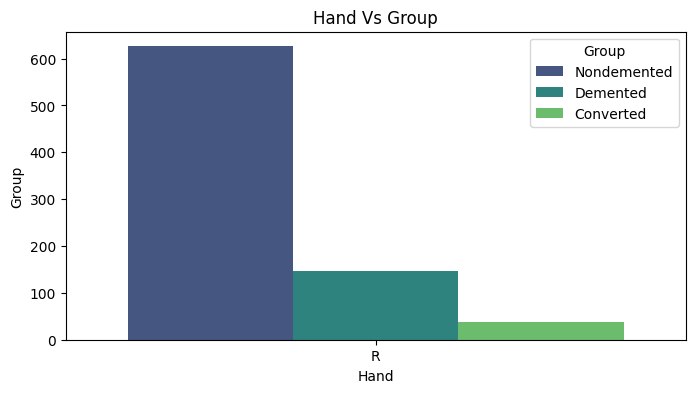

In [180]:
plt.figure(figsize=(8, 4))
sns.countplot(data=data, x='Hand', hue='Group', palette='viridis')

plt.title('Hand Vs Group')
plt.xlabel('Hand')
plt.ylabel('Group')
plt.show()

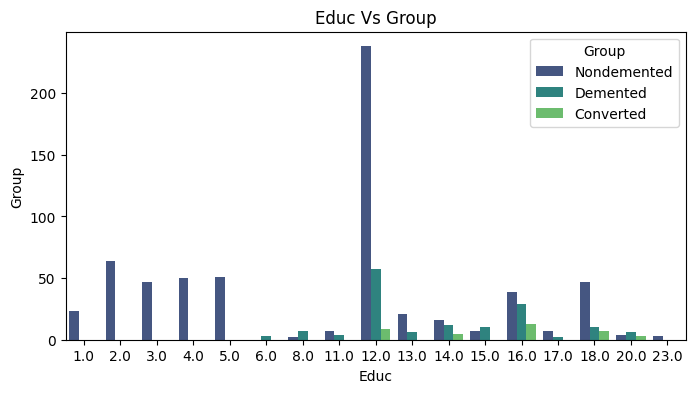

In [181]:
plt.figure(figsize=(8, 4))
sns.countplot(data=data, x='Educ', hue='Group', palette='viridis')

plt.title('Educ Vs Group')
plt.xlabel('Educ')
plt.ylabel('Group')
plt.show()

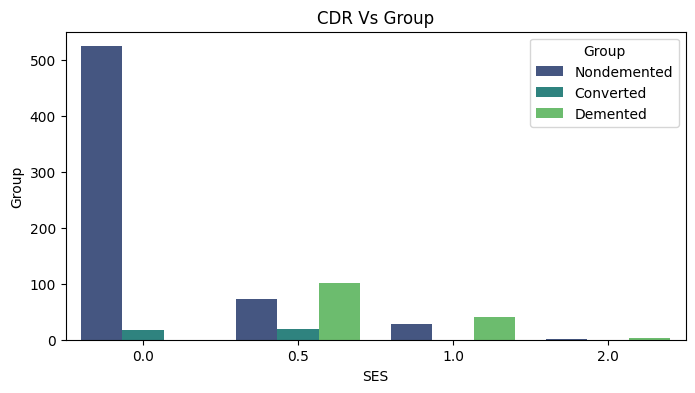

In [182]:
plt.figure(figsize=(8, 4))
sns.countplot(data=data, x='CDR', hue='Group', palette='viridis')

plt.title('CDR Vs Group')
plt.xlabel('SES')
plt.ylabel('Group')
plt.show()

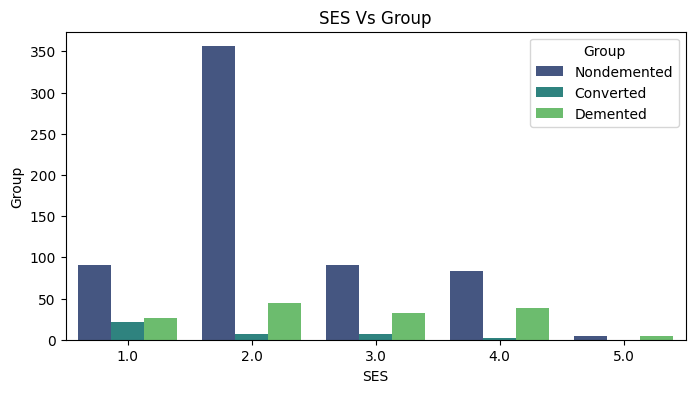

In [183]:
plt.figure(figsize=(8, 4))
sns.countplot(data=data, x='SES', hue='Group', palette='viridis')

plt.title('SES Vs Group')
plt.xlabel('SES')
plt.ylabel('Group')
plt.show()

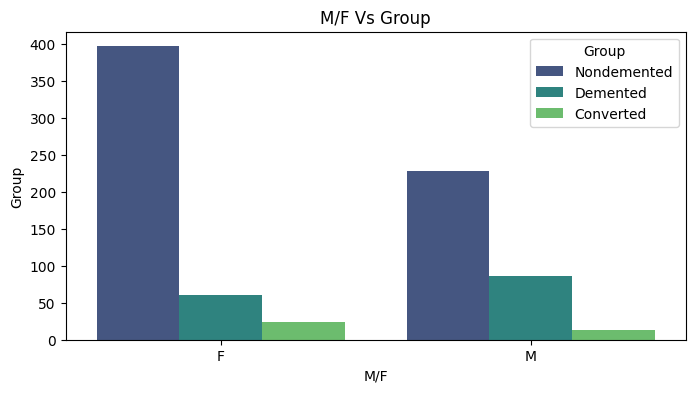

In [184]:
plt.figure(figsize=(8, 4))
sns.countplot(data=data, x='M/F', hue='Group', palette='viridis')

plt.title('M/F Vs Group')
plt.xlabel('M/F')
plt.ylabel('Group')
plt.show()

In [185]:
unique_values = data['Group'].unique()
print(unique_values)

['Nondemented' 'Demented' 'Converted']


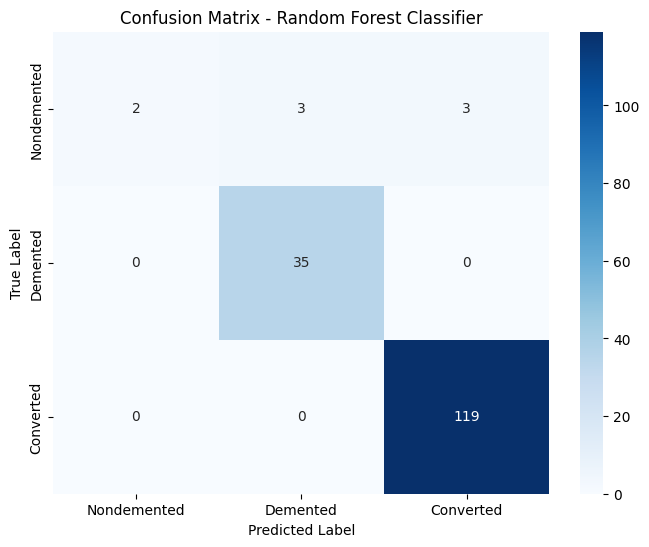

In [186]:
from sklearn.metrics import confusion_matrix

cm_rf = confusion_matrix(y_test_label, pipeline.predict(X_val))
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Nondemented', 'Demented', 'Converted'], yticklabels=['Nondemented', 'Demented', 'Converted'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Random Forest Classifier')
plt.show()

Text(0.5, 1.0, 'Confusion Matrix - XGBoost Classifier')

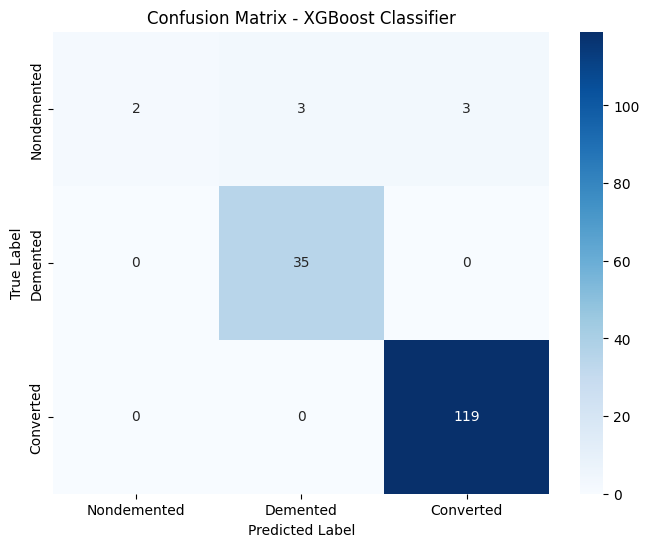

In [187]:
from sklearn.metrics import confusion_matrix

cm_rf = confusion_matrix(y_val, pipeline.predict(X_val))
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Nondemented', 'Demented', 'Converted'], yticklabels=['Nondemented', 'Demented', 'Converted'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - XGBoost Classifier')

In [188]:
from sklearn.metrics import classification_report

print("Classification Report - Random Forest Classifier:")
print(classification_report(y_test_label, pipeline.predict(X_val)))

Classification Report - Random Forest Classifier:
              precision    recall  f1-score   support

           0       1.00      0.25      0.40         8
           1       0.92      1.00      0.96        35
           2       0.98      1.00      0.99       119

    accuracy                           0.96       162
   macro avg       0.97      0.75      0.78       162
weighted avg       0.96      0.96      0.95       162



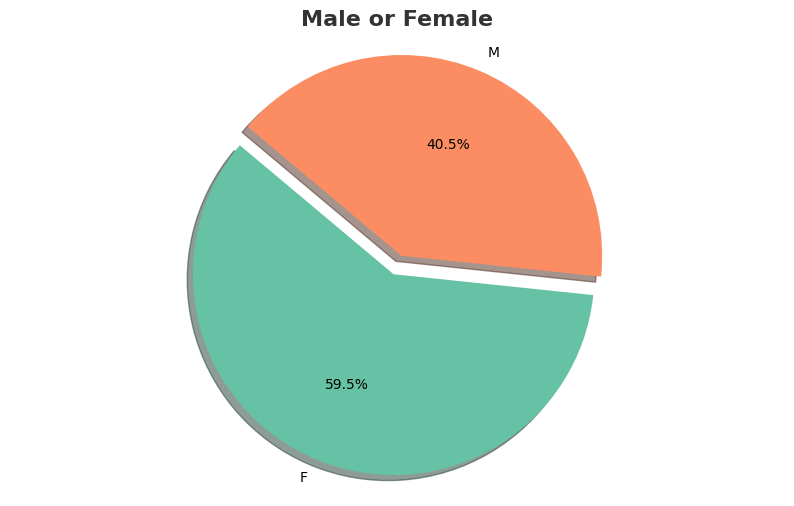

In [189]:
import pandas as pd
import matplotlib.pyplot as plt

potability_counts = data['M/F'].value_counts()

colors = ['#66c2a5', '#fc8d62']
explode = (0.1, 0)

plt.figure(figsize=(10, 6))
plt.pie(potability_counts, labels=potability_counts.index, autopct='%1.1f%%', startangle=140, colors=colors, explode=explode, shadow=True)
plt.title('Male or Female', fontsize=16, fontweight='bold', color='#333333')
plt.axis('equal')
plt.show()

In [190]:
data.columns

Index(['ID', 'M/F', 'Hand', 'Age', 'Educ', 'SES', 'MMSE', 'CDR', 'eTIV',
       'nWBV', 'ASF', 'Delay', 'Subject ID', 'MRI ID', 'Group', 'Visit',
       'MR Delay'],
      dtype='object')

In [191]:
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

In [192]:
fig = px.scatter(data, x="MMSE", y="Educ", color="Group")
fig.show()

In [193]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
}

In [194]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

accuracy = best_model.score(X_val, y_test_label)
print("Accuracy:", accuracy)

Accuracy: 0.9629629629629629


In [195]:
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier

In [196]:
preprocessor = ColumnTransformer(
    transformers=[
        ('scale', StandardScaler(), scale),
        ('ohe', OneHotEncoder(), ohe)
    ])

In [197]:
pipelines = {
    'RandomForest': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=42))
    ]),
    'SVM': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', SVC(probability=True, random_state=42))
    ]),
    'KNN': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', KNeighborsClassifier())
    ]),
    'LogisticRegression': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(random_state=42))
    ]),
    'XGBoost': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(random_state=42))
    ]),
    'GradientBoosting': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', GradientBoostingClassifier(random_state=42))
    ]),
    'DecisionTree': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier(random_state=42))
    ]),
    'CatBoost': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', CatBoostClassifier(random_state=42, verbose=0))
    ])
}

In [198]:
accuracies = {}

for name, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train_label)
    accuracy = pipeline.score(X_val, y_test_label)
    accuracies[name] = accuracy
    print(f'{name} Accuracy: {accuracy:.4f}')

RandomForest Accuracy: 0.9630
SVM Accuracy: 0.9259
KNN Accuracy: 0.9506
LogisticRegression Accuracy: 0.9012
XGBoost Accuracy: 0.9630
GradientBoosting Accuracy: 0.9630
DecisionTree Accuracy: 0.9383
CatBoost Accuracy: 0.9630


In [199]:
svm_clf = SVC(probability=True)
knn_clf = KNeighborsClassifier()
lr_clf = LogisticRegression()
xgb_clf = XGBClassifier()
gbm_clf = GradientBoostingClassifier(random_state=42)
dt_clf = DecisionTreeClassifier(random_state=42)
catboost_clf = CatBoostClassifier(random_state=42)

In [200]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[
        ('svm', svm_clf),
        ('knn', knn_clf),
        ('lr', lr_clf),
        ('xgb', xgb_clf),
        ('gbm', gbm_clf),
        ('dt', dt_clf),
        ('catboost', catboost_clf)
    ],
    voting='soft'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', voting_clf)
])

In [201]:
pipeline.fit(X_train, y_train_label)

accuracy = pipeline.score(X_val, y_test_label)
print(f'Model Accuracy: {accuracy}')

Learning rate set to 0.077389
0:	learn: 0.9914731	total: 2.63ms	remaining: 2.62s
1:	learn: 0.9063640	total: 4.98ms	remaining: 2.49s
2:	learn: 0.8276196	total: 7.33ms	remaining: 2.44s
3:	learn: 0.7606386	total: 9.71ms	remaining: 2.42s
4:	learn: 0.7020445	total: 12.1ms	remaining: 2.41s
5:	learn: 0.6487868	total: 14.5ms	remaining: 2.4s
6:	learn: 0.6077989	total: 16.8ms	remaining: 2.38s
7:	learn: 0.5716511	total: 19.1ms	remaining: 2.37s
8:	learn: 0.5376047	total: 21.4ms	remaining: 2.36s
9:	learn: 0.5059299	total: 23.7ms	remaining: 2.35s
10:	learn: 0.4779844	total: 26ms	remaining: 2.33s
11:	learn: 0.4538964	total: 28.3ms	remaining: 2.33s
12:	learn: 0.4302521	total: 30.6ms	remaining: 2.32s
13:	learn: 0.4129904	total: 32.9ms	remaining: 2.31s
14:	learn: 0.3937267	total: 35.2ms	remaining: 2.31s
15:	learn: 0.3766470	total: 37.6ms	remaining: 2.31s
16:	learn: 0.3595019	total: 40ms	remaining: 2.31s
17:	learn: 0.3446241	total: 42.2ms	remaining: 2.3s
18:	learn: 0.3328664	total: 44.6ms	remaining: 2.3s